# Resolving Names of Complexes

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt/)

**Estimated Runtime**:

Often in BEL documents, complexes are named by their members. Additional information might be avaliable from other sources, so these complexes should be resolved to their external names if possible.

In this investigation, the human `9-1-1 Complex` is resolved while other complexes without names are left.

In [1]:
import itertools as itt
import math
import os
import time

import matplotlib.pyplot as plt
import networkx as nx
import pybel
import pybel_tools as pbt
from pybel.constants import *
from pybel_tools.visualization import to_jupyter

%matplotlib inline

In [2]:
pybel.__version__

'0.7.2'

In [3]:
pbt.__version__

'0.1.18-dev'

In [4]:
time.asctime()

'Sun Aug 13 13:54:23 2017'

## Prior Knowledge

The OpenBEL Framework provides a listing of named complexes, organized as BEL statements. This can be loaded from URL using PyBEL.

In [5]:
manager = pybel.manager.CacheManager()

In [6]:
url = "http://resources.openbel.org/belframework/20150611/resource/named-complexes.bel"
graph = pybel.from_url(url, manager=manager)

ERROR:pybel.io.line_utils:Missing required document metadata: ContactInfo


In [7]:
graph.number_of_nodes(), graph.number_of_edges()

(1157, 1138)

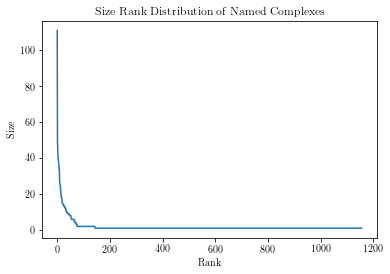

In [8]:
plt.title("Size Rank Distribution of Named Complexes")
plt.xlabel("Rank")
plt.ylabel("Size")
plt.plot(sorted([graph.degree(c) for c in graph], reverse=True))
plt.show()

During parsing and compiling, PyBEL transforms each complex into a canonical tuple that consists of the names of each of its members. The prior knowledge graph contains orthologous proteins for each complex, so the members are filtered to match human proteins with `HGNC` identifiers, rather than `MGI` or `RDB`. A mapping is built from the canonical tuple to its name.

In [9]:
# build mapping
t2n = {}
relabel_mapping = {}
for node in pbt.filters.get_nodes_by_function(graph, COMPLEX):
    data = graph.node[node]

    members = [
        member for member in graph.edge[node] if graph.node[member][NAMESPACE] == "HGNC"
    ]

    t = (COMPLEX,) + tuple(sorted(members))
    t2n[t] = data
    relabel_mapping[t] = node

# Resolution

A test BEL network is parsed and shown before complex name resolution. Here, the `9-1-1 complex` written as `complex(p(HGNC:HUS1), p(HGNC:RAD1), p(HGNC:RAD9A))`

In [10]:
test_bel = """SET DOCUMENT Name = "PyBEL Test Document"
SET DOCUMENT Description = "Made for testing PyBEL parsing"
SET DOCUMENT Version = "1.6.0"
SET DOCUMENT Copyright = "Copyright (c) Charles Tapley Hoyt. All Rights Reserved."
SET DOCUMENT Authors = "Charles Tapley Hoyt"
SET DOCUMENT Licenses = "Other / Proprietary"
SET DOCUMENT ContactInfo = "charles.hoyt@scai.fraunhofer.de"
DEFINE NAMESPACE ChEBI AS URL "http://resources.openbel.org/belframework/20150611/namespace/chebi.belns"
DEFINE NAMESPACE HGNC AS URL "http://resources.openbel.org/belframework/20150611/namespace/hgnc-human-genes.belns"
SET Citation = {"Other","Test Title","123456"}
SET Evidence = "Evidence 1"
complex(p(HGNC:HUS1), p(HGNC:RAD1), p(HGNC:RAD9A)) increases a(ChEBI:"oxygen radical")
complex(p(HGNC:SFN), p(HGNC:YWHAB)) cnc a(ChEBI:"oxygen radical")"""

target_graph = pybel.from_lines(test_bel.split("\n"), manager=manager)

In [11]:
to_jupyter(target_graph, replace_cnames=True)

<IPython.core.display.Javascript object>

Finally, the complexes are quickly matched with the mapping dictionary. The appropriate annotations are added, and the node is renamed. The network is shown again with the resolved nodes.

In [12]:
# fix node data
for c in pbt.filters.get_nodes_by_function(target_graph, COMPLEX):
    if c in t2n:
        print("matched")
        target_graph.node[c].update(t2n[c])

matched


In [13]:
to_jupyter(target_graph, replace_cnames=True)

<IPython.core.display.Javascript object>

# Conclusions

Resolution of complexes to proper names allows for better semantic integration. In the future, PyBEL will include the process outlined in this notebook as a built-in post-processing tool, using the resources from the OpenBEL Framework eventually from the original sources.